In [141]:
from google.colab import drive
drive.mount('/MyDrive', force_remount=True)

Mounted at /MyDrive


In [142]:
PATH = '/MyDrive/MyDrive/CapstoneWork/'

In [3]:
!pip install endplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.3/296.3 kB 2.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import endplay
from endplay.dealer import generate_deal
from endplay.dealer import generate_deals
import endplay.dds as dds
from endplay.types import Player, Denom


In [5]:
def generate_table(deal):
  dd_result = dds.calc_dd_table(deal)
  uncorrected_array = np.array(dd_result.to_list(), dtype = np.uint8)
  array = (uncorrected_array.T)[[0, 2, 1, 3]][:,[3, 2, 1, 0, 4]]
  dd_result.pprint()
  return array

In [6]:
def generate_tables(num):
  deals = generate_deals(produce = num)


  dd_results = dds.calc_all_tables(deals)
  uncorrected_array = np.array([np.array(x.to_list(), dtype = np.uint8) for x in dd_results])
  array = uncorrected_array.swapaxes(1, 2)
  array = array[:,[0, 2, 1, 3]][:, :,[3, 2, 1, 0, 4]]
  return array

In [7]:
from endplay.types import Player, Denom

char_map = {c:i for i,c in enumerate('AKQJT98765432')}

def create_hand_array(deal):
    suit_multiplier = 0
    values = np.zeros((4, 52), dtype=bool)
    for player_idx, player in enumerate([Player.north, Player.south, Player.east, Player.west]):
      for suit_idx, suit in enumerate([Denom.spades, Denom.hearts, Denom.diamonds, Denom.clubs]):
        suit_shift = 13 * suit_idx
        for x in str(deal[player][suit]):
            rank = char_map[x]
            values[player_idx, suit_shift + rank] = True
    return values

In [8]:
def create_tables(deals):
  dd_results = dds.calc_all_tables(deals)
  uncorrected_array = np.array([np.array(x.to_list(), dtype = np.uint8) for x in dd_results])
  contracts_unformatted = uncorrected_array.swapaxes(1, 2)
  contracts = contracts_unformatted[:,[0, 2, 1, 3]][:, :,[3, 2, 1, 0, 4]]
  cards = np.array([create_hand_array(x) for x in deals])
  return cards, contracts

In [9]:
def generate_data(num):
  cards = []
  contracts = []
  num_remaining = num
  while num_remaining > 0:
    to_generate = min(40, num_remaining)
    num_remaining = num_remaining - to_generate
    deals = [x for x in generate_deals(produce=to_generate)]
    crd, cntr = create_tables(deals)
    cards += [crd]
    contracts += [cntr]


  return np.row_stack(cards), np.row_stack(contracts)



In [10]:
import os
def create_files(path, cards, contracts):
  if os.path.isfile(path):
    return
  np.savez_compressed(path, cards, contracts)
  return


In [11]:
def generate_data_timeout(num):
  cards = []
  contracts = []
  num_remaining = num

  while num_remaining > 0:
    to_generate = min(40, num_remaining)
    num_remaining = num_remaining - to_generate
    deals = [x for x in generate_deals(produce=to_generate)]
    crd, cntr = create_tables(deals)
    cards += [crd]
    contracts += [cntr]


  return np.row_stack(cards), np.row_stack(contracts)

In [12]:
import time

def save_data(path, array):
  x = array
  if os.path.isfile(path):
    loaded = np.load(path)
    x = np.concatenate((loaded, array))
  print(x.shape)
  np.save(path, x)



def generate_data_with_timeout(secs: int, iters_to_save: int, final_path = PATH + "data/temp", produce = 40):
  """
  Generates data for 'secs' length. Does not terminate after secs, finishes last run
  """
  cards = []
  contracts = []
  final = time.time() + secs
  iter = 0
  card_path = final_path + "card.npy"
  contracts_path = final_path + "contracts.npy"
  while time.time() < final:
    deals = [x for x in generate_deals(produce=produce)]
    crd, cntr = create_tables(deals)
    cards += [crd]
    contracts += [cntr]
    iter += 1
    if iters_to_save != None and iter % iters_to_save == 0:
      save_data(card_path, np.row_stack(cards))
      save_data(contracts_path, np.row_stack(contracts))
      cards=[]
      contracts = []
  if len(cards) >= 2:
    save_data(card_path, np.row_stack(cards))
    save_data(contracts_path, np.row_stack(contracts))




In [13]:
def featurize_hand_ranks(cards_array):
  features = []
  for i in range(13):
    counts = np.count_nonzero(cards_array[..., [i, i + 13, i + 26, i+39]], axis=-1)
    features += [counts]
  return np.stack(features, axis = -1)


In [14]:
def featurize_hand_suits(cards_array):
  features = []
  for i in range(4):
    counts = np.count_nonzero(cards_array[..., i * 13:(i+1) * 13], axis=-1)
    features += [counts]
  return np.stack(features, axis = -1)

In [15]:
def does_game_make(contracts_array):
  game_level = [[[11, 11, 10, 10, 9]]]
  making_games = contracts_array >= game_level
  return making_games

In [16]:
def compile_all_data(path = PATH + 'data/'):
  print(path)
  directory = os.listdir(path)
  cards = []
  contracts = []
  for filename in directory:
    if filename.endswith('card.npy'):
      cards += [filename]
    if filename.endswith('contracts.npy'):
      contracts += [filename]
  cards.sort()
  contracts.sort()
  print(cards)
  print(contracts)
  for x, y in zip(cards, contracts):
    assert(x[0:-8] == y[0:-13])

  np_cards = [np.load(path + x) for x in cards]
  np_contracts = [np.load(path + x) for x in contracts]

  final_cards = np.row_stack(np_cards)
  final_contracts = np.row_stack(np_contracts)

  assert(final_cards.shape[0] == final_contracts.shape[0])

  return final_cards, final_contracts









In [17]:
cards, contracts = compile_all_data()

/MyDrive/MyDrive/CapstoneWork/data/
['5_09card.npy', '5_13card.npy', 'init_1hrcard.npy', 'overnight1card.npy', 'overnight2card.npy', 'tempcard.npy']
['5_09contracts.npy', '5_13contracts.npy', 'init_1hrcontracts.npy', 'overnight1contracts.npy', 'overnight2contracts.npy', 'tempcontracts.npy']


In [18]:
import pandas as pd
def build_df(np_array):
  reshaped = np_array.reshape(-1, np_array.shape[-1])
  df = pd.DataFrame(reshaped)
  df['hand_num'] = df.index // 4
  df['seat'] = df.index % 4
  df = df.set_index(['hand_num', 'seat'])
  hand_to_direction = {i:x for i, x in enumerate(["north", "south", "east", "west"])}
  df.rename(index=hand_to_direction, level='seat', inplace=True)
  return df




In [19]:
cards_df = build_df(cards)
contracts_df = build_df(contracts)
contracts_df.rename(columns = {i:x for i, x in enumerate(["clubs", "diamonds", "hearts", "spades", "no_trump"])})

clubs  diamonds  hearts  spades  no_trump
hand_num seat                                            
0        north      1         6       3       5         5
         south      1         6       3       5         5
         east      12         6      10       7         8
         west      12         6      10       8         8
1        north     10         4      11       8         5
...               ...       ...     ...     ...       ...
253582   west       5         5       7       4         7
253583   north      4         2       5       4         3
         south      4         2       5       4         3
         east       9        11       7       9        10
         west       9        11       8       9        10

[1014336 rows x 5 columns]

In [143]:
contracts_df.to_csv(PATH + "data/final_contracts")

In [20]:
cards_df

0      1      2      3      4      5      6      7      8   \
hand_num seat                                                                   
0        north  False   True  False  False   True  False   True  False  False   
         south  False  False  False  False  False   True  False   True   True   
         east   False  False   True  False  False  False  False  False  False   
         west    True  False  False   True  False  False  False  False  False   
1        north   True  False  False  False  False  False  False  False  False   
...               ...    ...    ...    ...    ...    ...    ...    ...    ...   
253582   west   False  False  False  False   True   True   True  False  False   
253583   north  False  False  False   True   True  False   True  False  False   
         south  False   True  False  False  False  False  False  False  False   
         east   False  False  False  False  False   True  False   True  False   
         west    True  False   True  False  False  False  False  False   True   

                   9   ...     42     43     44     45     46     47     48  \
hand_num seat          ...                                                    
0        north  False  ...  False   True  False  False  False  False  False   
         south  False  ...  False  False   True  False   True  False  False   
         east   False  ...   True  False  False  False  False   True  False   
         west    True  ...  False  False  False   True  False  False   True   
1        north  False  ...   True  False  False  False  False  False  False   
...               ...  ...    ...    ...    ...    ...    ...    ...    ...   
253582   west   False  ...  False   True  False  False  False  False  False   
253583   north  False  ...   True  False  False   True  False   True  False   
         south   True  ...  False  False  False  False   True  False  False   
         east   False  ...  False   True  False  False  False  False   True   
         west   False  ...  False  False   True  False  False  False  False   

                   49     50     51  
hand_num seat                        
0        north   True  False  False  
         south  False  False  False  
         east   False   True   True  
         west   False  False  False  
1        north  False   True  False  
...               ...    ...    ...  
253582   west    True  False   True  
253583   north  False  False   True  
         south  False  False  False  
         east    True   True  False  
         west   False  False  False  

[1014336 rows x 52 columns]

In [144]:
contracts_df.to_csv(PATH + "data/final_cards")

In [21]:
suits = featurize_hand_suits(cards)
suits_df = build_df(suits)
suits_df.rename(columns = {i:x for i, x in enumerate(reversed(["clubs", "diamonds", "hearts", "spades"]))})


spades  hearts  diamonds  clubs
hand_num seat                                  
0        north       3       3         5      2
         south       4       3         4      2
         east        3       5         1      4
         west        3       2         3      5
1        north       3       6         1      3
...                ...     ...       ...    ...
253582   west        3       5         2      3
253583   north       4       3         1      5
         south       3       5         4      1
         east        2       2         3      6
         west        4       3         5      1

[1014336 rows x 4 columns]

In [22]:
ranks = featurize_hand_ranks(cards)
ranks_df = build_df(ranks)
ranks_df.rename(columns = {x:y for x, y in enumerate("AKQJT98765432")}, inplace=True)



In [23]:
ranks_df["trad_hcp"] = 4 * ranks_df["A"] + 3 * ranks_df['K'] + 2 * ranks_df['Q'] + ranks_df['J']

In [24]:
ranks_df["trad_hcp"]

hand_num  seat 
0         north    12
          south     5
          east      9
          west     14
1         north    12
                   ..
253582    west      8
253583    north     8
          south     7
          east     10
          west     15
Name: trad_hcp, Length: 1014336, dtype: int64

In [66]:
from sklearn.model_selection import train_test_split

# Assuming you have your data stored in X (features) and y (labels/targets) arrays
X_train, X_test, y_train, y_test = train_test_split(ranks, contracts, test_size=0.2, random_state=1)

In [67]:
X_test.shape[0] * 2

101434

In [68]:
def split_partnerships(df):
  ns = df.filter(items=['north', 'south'])
  print(ns)
  ns["hand_num"] = ns["hand_num"] * 2
  ew = df.filter(items = ['east', 'west'])
  ew["hand_num"] = ew["hand_num"] * 2 + 1
  return pd.concat(ns, ew)


In [69]:
def seperate_partnerships_np(array):
  north_south = array[...,[0,1], :]
  east_west = array[...,[2,3], :]
  return north_south, east_west


In [70]:
def remake_split(np_array):
  ns, ew = seperate_partnerships_np(np_array)
  return np.row_stack((ns, ew))

In [71]:
X_train = remake_split(X_train)
X_test = remake_split(X_test)
y_train = remake_split(y_train)
y_test = remake_split(y_test)

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example boolean lists for actual and predicted values

def create_confusion_matrix(actual, predicted, title='Confusion Matrix'):
  # Create confusion matrix
  cm = confusion_matrix(actual, predicted)

  # Plot confusion matrix
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  #plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, ['False', 'True'])
  plt.yticks(tick_marks, ['False', 'True'])

  # Add labels to each cell
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          plt.text(j, i, format(cm[i, j], 'd'),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.tight_layout()
  plt.show()

In [73]:
# Pure heuristic result
def compute_partnership_hcp(ranks_array, values = [4, 3, 2, 1]):
  hcp = np.sum(ranks_array[...,0:len(values)] * [[values]], axis=(1, 2))
  return hcp

summed_hcp = compute_partnership_hcp(X_test)
predictions = summed_hcp >= 25
print(predictions.shape)

actual = np.any(does_game_make(y_test), axis = (1, 2))
print(actual.shape)

(101434,)
(101434,)


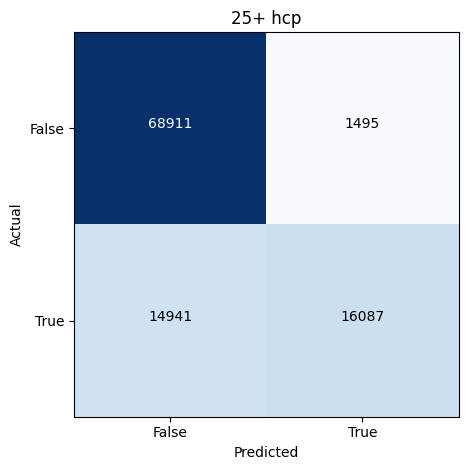

In [77]:
create_confusion_matrix(actual, predictions, title = "25+ hcp")

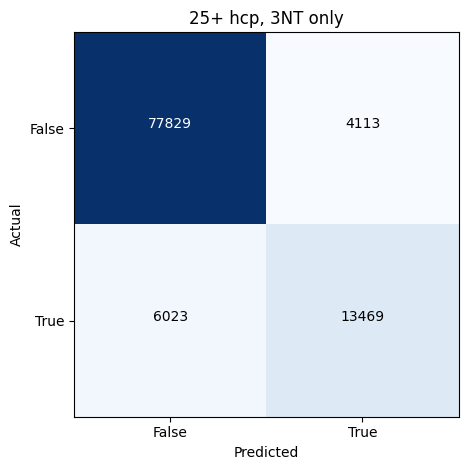

In [78]:
#Just 3NT
actual = np.any(does_game_make(y_test)[...,4], axis = 1)
create_confusion_matrix(actual, predictions, "25+ hcp, 3NT only")

In [34]:
print(compute_partnership_hcp(X_train).shape)
print(np.any(does_game_make(y_train), axis = (1, 2)).shape)

(405734,)
(405734,)


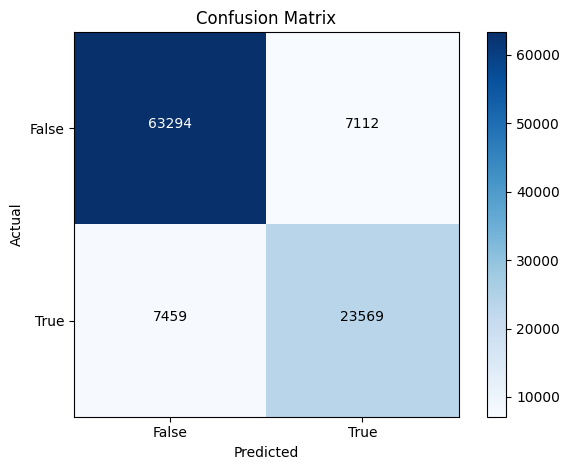

In [35]:
#learned hcp_threshold, any game
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(np.expand_dims(compute_partnership_hcp(X_train), axis=1), np.any(does_game_make(y_train), axis = (1, 2)))
test_reshape = np.expand_dims(compute_partnership_hcp(X_test), axis=1)
create_confusion_matrix(np.any(does_game_make(y_test), axis = (1, 2)), model.predict(test_reshape))

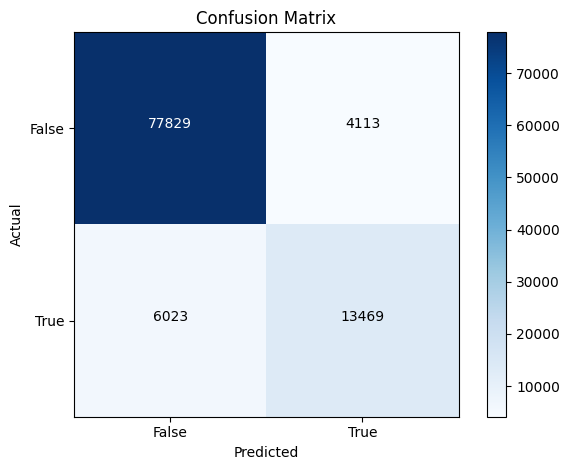

In [36]:
model = LogisticRegression()
model.fit(np.expand_dims(compute_partnership_hcp(X_train), axis=1), np.any(does_game_make(y_train)[...,4], axis = 1))
test_reshape = np.expand_dims(compute_partnership_hcp(X_test), axis=1)
create_confusion_matrix(np.any(does_game_make(y_test)[...,4], axis = 1), model.predict(test_reshape))

In [37]:
model.intercept_ / model.coef_

array([[-24.69642762]])

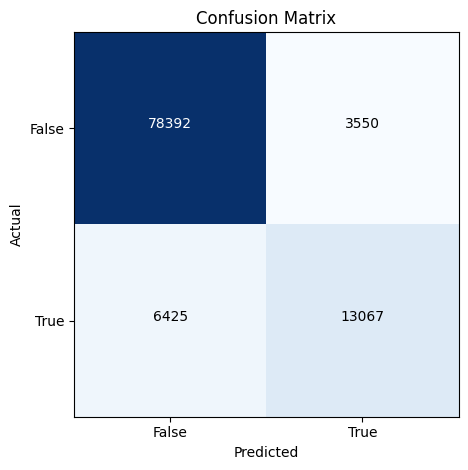

In [79]:
model = LogisticRegression()
model.fit(np.sum(X_train[...,0:4], axis=1), np.any(does_game_make(y_train)[...,4], axis = 1))
create_confusion_matrix(np.any(does_game_make(y_test)[...,4], axis = 1), model.predict(np.sum(X_test[...,0:4], axis=1)))

In [81]:
scaling_constant = 10 / np.sum(model.coef_)
print(model.coef_)
print(model.coef_ * scaling_constant)
print(model.intercept_)
print(model.intercept_ * scaling_constant)



[[3.22183554 2.10963239 1.22395946 0.61438125]]
[[4.49361441 2.94238312 1.70710199 0.85690048]]
[-17.88093257]
[-24.93920478]


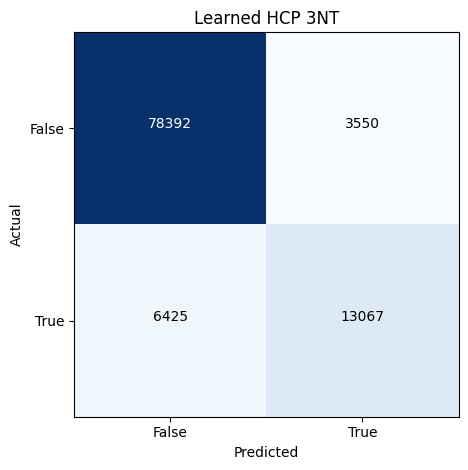

In [111]:
model = LogisticRegression()
model.fit(np.sum(X_train[...,0:4], axis=1), np.any(does_game_make(y_train)[...,4], axis = 1))
create_confusion_matrix(np.any(does_game_make(y_test)[...,4], axis = 1), model.predict(np.sum(X_test[...,0:4], axis=1)), title="Learned HCP 3NT")

In [137]:
print(model.coef_)
scaling = 10 / np.sum(model.coef_)
print(model.coef_ * scaling)
print(model.intercept_)
print(model.intercept_ * scaling)

# print(coef * scaling_constant)
# print(model.coef_ * scaling_constant)
# print(model.intercept_)
# print(model.intercept_ * scaling_constant)


[[4.00332443 2.88947281 1.90058858 1.0806454 ]]
[[4.05439717 2.92633551 1.9248355  1.09443182]]
[-24.00097999]
[-24.30717451]


In [39]:
model.coef_ * 10 / np.sum(model.coef_)

array([[4.49361441, 2.94238312, 1.70710199, 0.85690048]])

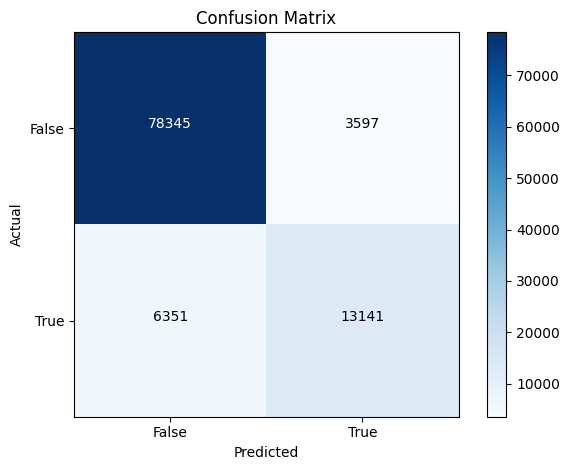

In [40]:
# Metric issue with logistic
model = LogisticRegression()
model.fit(np.sum(X_test[...,0:4], axis=1), np.any(does_game_make(y_test)[...,4], axis = 1))
create_confusion_matrix(np.any(does_game_make(y_test)[...,4], axis = 1), model.predict(np.sum(X_test[...,0:4], axis=1)))

In [41]:
model.coef_ * 10 / np.sum(model.coef_)

array([[4.50316024, 2.90719834, 1.6919726 , 0.89766882]])

In [42]:
model.intercept_ * 10 / np.sum(model.coef_)

array([-24.89786516])

In [43]:
partnership_suit_totals = np.sum(remake_split(featurize_hand_suits(cards)), axis=1)

In [44]:
partnership_suit_totals.shape

(507168, 4)

In [113]:
x = np.all(remake_split(featurize_hand_suits(cards)) >= 2, axis=(1, 2))

In [116]:
np.count_nonzero(x)

215866

In [45]:
no_fit = np.all(partnership_suit_totals < 8, axis = -1)

In [112]:
count = np.count_nonzero(no_fit)
print(count)
print(count / partnership_suit_totals.shape[0])

79956
0.1576519023282226


In [128]:
X_train, X_test, y_train, y_test = train_test_split(remake_split(ranks)[no_fit], remake_split(contracts)[no_fit], test_size=0.2, random_state=1)

In [118]:
X_test.shape

(15992, 2, 13)

(15992,)


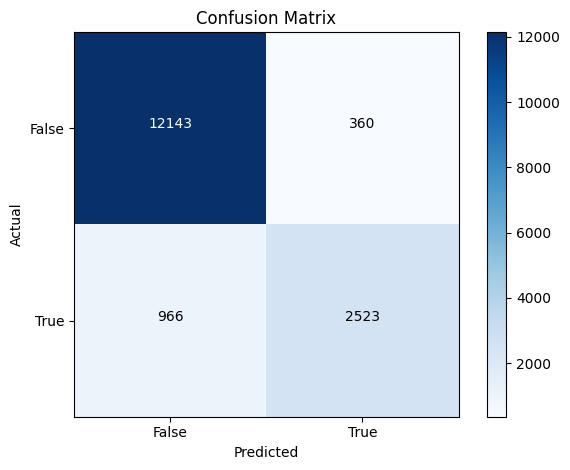

In [47]:
summed_hcp = compute_partnership_hcp(X_test)
predictions = summed_hcp >= 25
print(predictions.shape)

actual = np.any(does_game_make(y_test), axis = (1, 2))
create_confusion_matrix(actual, predictions)

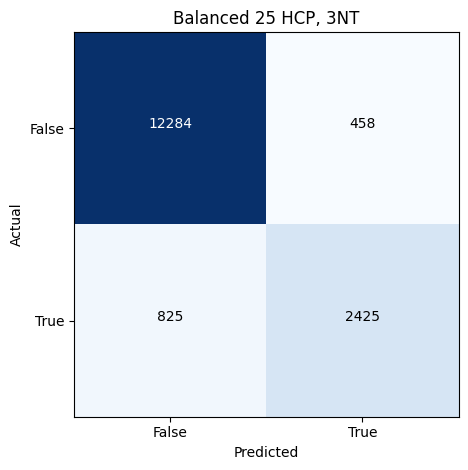

In [130]:
summed_hcp = compute_partnership_hcp(X_test)
predictions = summed_hcp >= 25

actual = np.any(does_game_make(y_test)[...,4], axis = 1)
create_confusion_matrix(actual, predictions, title = 'Balanced 25 HCP, 3NT')

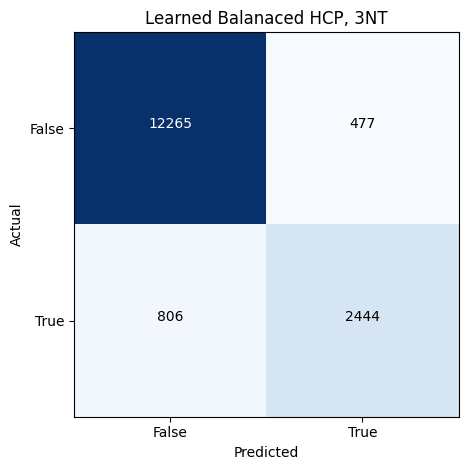

In [138]:
model = LogisticRegression()
model.fit(np.sum(X_train[...,0:4], axis=1), np.any(does_game_make(y_train)[...,4], axis = 1))
test_reshape = np.sum(X_test[...,0:4], axis=1)
create_confusion_matrix(np.any(does_game_make(y_test)[...,4], axis = 1), model.predict(test_reshape), "Learned Balanaced HCP, 3NT")

In [133]:
model.coef_ * 10 / np.sum(model.coef_)

array([[4.05439717, 2.92633551, 1.9248355 , 1.09443182]])

In [136]:
model.intercept_ * 10 / np.sum(model.coef_)

array([-24.30717451])

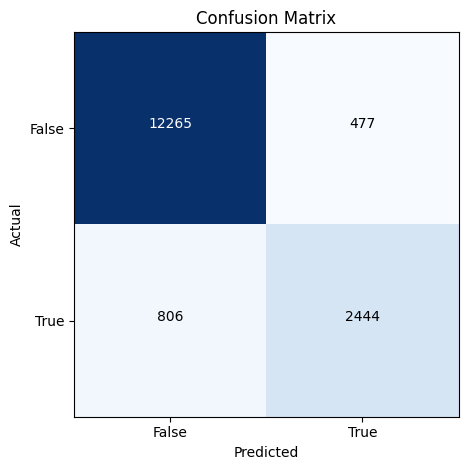

In [120]:
model = LogisticRegression()
model.fit(np.sum(X_train[...,0:4], axis=1), np.any(does_game_make(y_train)[...,4], axis = 1))
test_reshape = np.sum(X_test[...,0:4], axis=1)
create_confusion_matrix(np.any(does_game_make(y_test)[...,4], axis = 1), model.predict(test_reshape))

In [122]:
X_train, X_test, y_train, y_test = train_test_split(remake_split(ranks)[x], remake_split(contracts)[x], test_size=0.2, random_state=1)

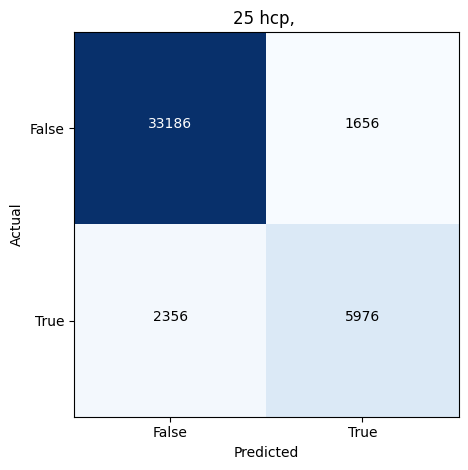

In [123]:
summed_hcp = compute_partnership_hcp(X_test)
predictions = summed_hcp >= 25

actual = np.any(does_game_make(y_test)[...,4], axis = 1)
create_confusion_matrix(actual, predictions, title = '25 hcp, ')

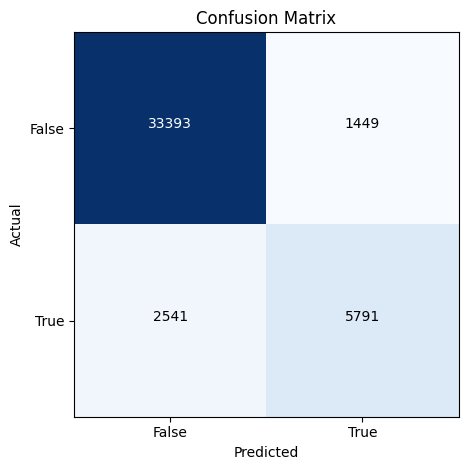

In [124]:
model = LogisticRegression()
model.fit(np.sum(X_train[...,0:4], axis=1), np.any(does_game_make(y_train)[...,4], axis = 1))
test_reshape = np.sum(X_test[...,0:4], axis=1)
create_confusion_matrix(np.any(does_game_make(y_test)[...,4], axis = 1), model.predict(test_reshape))

In [126]:
model.coef_ * 10 / np.sum(model.coef_)

array([[4.39027291, 2.95394481, 1.75780236, 0.89797992]])

In [127]:
model.intercept_ * 10 / np.sum(model.coef_)

array([-24.83703433])

In [ ]:
np.count_nonzero((hcp >= 23) == ns_makes_any_game) / hcp_25_correct.shape[0]

In [ ]:
does_3NT_make = np.any(does_game_make(ns_contracts)[..., 4], axis=-1)

In [ ]:
for i in range(22, 27):
  correct = (hcp >= i)
  percent = np.count_nonzero(correct == does_3NT_make) / correct.shape[0]
  print(percent)


In [ ]:
model = LogisticRegression()

In [ ]:
np.stack(np.sum(featurize_hand_ranks(ns_cards)[...,0:4], axis = 1), np.array([[1]]))

In [ ]:
X_train = np.sum(featurize_hand_ranks(ns_cards)[...,0:4], axis = 1)

In [ ]:
X_train[0]

In [ ]:
model.fit(X_train, does_3NT_make)

In [ ]:
np.count_nonzero(model.predict(X_train) == does_3NT_make) / does_3NT_make.shape[0]

In [ ]:
model.coef_

In [ ]:
model.intercept_

In [ ]:
model.coef_ * (-25 / model.intercept_)

In [ ]:
model2 = LogisticRegression()

In [ ]:
model2.fit(X_train, ns_makes_any_game)

In [ ]:
model2.coef_

In [ ]:
model2.intercept_

In [ ]:
model2.coef_ * 10 / np.sum(model2.coef_)

In [ ]:
time.time()

In [ ]:
if time.time() < 1715138857 + 300:
  generate_data_with_timeout(3600 * 9, 5, PATH + 'data/overnight3')

In [ ]:
model2.intercept_ * 10 / np.sum(model2.coef_)